## Read the **dataset**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

In [5]:
# DenseNet Dependencies
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.layers import Dense,Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC, BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201, VGG16, ResNet50
from tensorflow.keras.losses import categorical_crossentropy
from keras import backend as K
from tensorflow.keras import Sequential
import keras
import matplotlib
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from sklearn.metrics import roc_curve, auc

In [6]:
# Unzip file
with zipfile.ZipFile("/content/drive/MyDrive/Teeth DataSet.zip", "r") as zip_ref:
    zip_ref.extractall("dataset")

# Check files
os.listdir("dataset")


['Teeth_Dataset']

In [7]:
data_dir = "/content/dataset/Teeth_Dataset"

os.listdir(data_dir)

['Testing', 'Training', 'Validation']

In [8]:
for Dataset in os.listdir(data_dir):
    class_path = os.path.join(data_dir, Dataset)
    if os.path.isdir(class_path):  # make sure it's a folder
        num_images = len(os.listdir(class_path))
        print(f"{Dataset}: {num_images} Class")

Testing: 11 Class
Training: 7 Class
Validation: 7 Class


In [9]:
test_dir = os.path.join(data_dir, "Testing")
train_dir=os.path.join(data_dir, "Training")
val_dir=os.path.join(data_dir, "Validation")
os.listdir(test_dir)

['outputs',
 'CoS',
 'output_image.jpg',
 'Gum',
 'OT',
 'OLP',
 'CaS',
 'MC',
 'output',
 'OC',
 'out']

In [10]:
import shutil
#List of unwanted files/folders
to_delete = ['outputs', 'output', 'output_image.jpg','out']

for item in to_delete:
    item_path = os.path.join(test_dir, item)

    if os.path.isdir(item_path):
        shutil.rmtree(item_path)   # delete folder and its contents
        print(f"Deleted folder: {item}")
    elif os.path.isfile(item_path):
        os.remove(item_path)       # delete file
        print(f"Deleted file: {item}")
    else:
        print(f"Not found: {item}")

Deleted folder: outputs
Deleted folder: output
Deleted file: output_image.jpg
Deleted folder: out


## Data Preprocessing

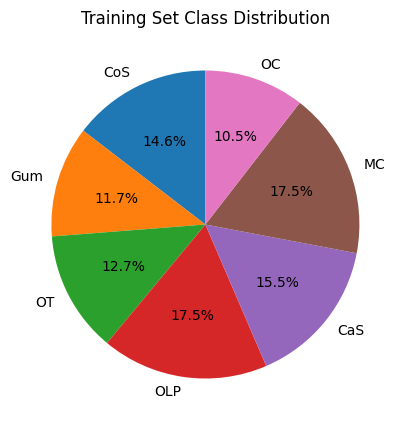

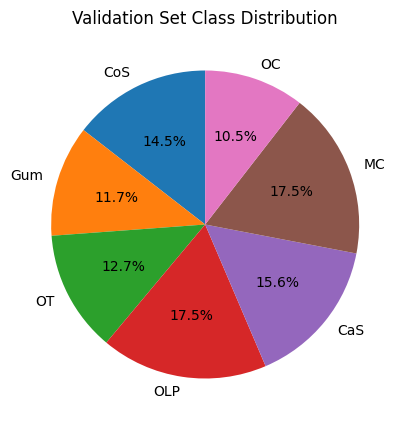

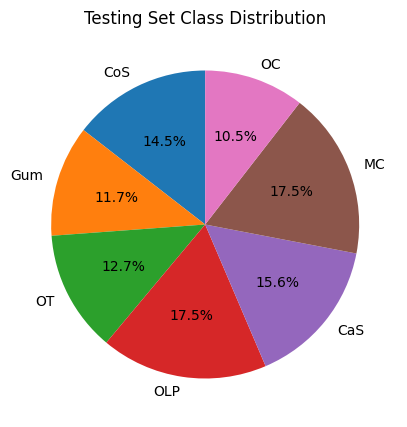

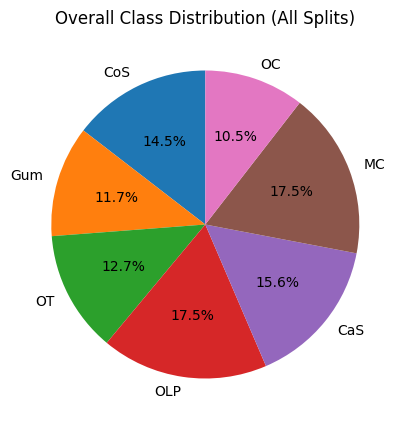

In [11]:
# Dictionary to accumulate totals across all splits
overall_counts = {}

# Loop over the dataset splits
for split in ["Training", "Validation", "Testing"]:
    split_path = os.path.join(data_dir, split)

    class_counts = {}

    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_name] = num_images

            # Add to overall totals
            overall_counts[class_name] = overall_counts.get(class_name, 0) + num_images

    # Pie chart for each split
    plt.figure(figsize=(5, 5))
    plt.pie(
        class_counts.values(),
        labels=class_counts.keys(),
        autopct='%1.1f%%',
        startangle=90
    )
    plt.title(f"{split} Set Class Distribution")
    plt.show()

# ✅ One big pie chart for all classes across all splits
plt.figure(figsize=(5, 5))
plt.pie(
    overall_counts.values(),
    labels=overall_counts.keys(),
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Overall Class Distribution (All Splits)")
plt.show()

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

# Create generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=(0.8,1.2),
    fill_mode='nearest'
)


val_datagen = ImageDataGenerator(rescale=1./255)  # only rescale for validation

# Apply to directories
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255) # only rescale for testing
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [13]:
def get_callbacks(model_name):
    callbacks =[]

    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'model.{model_name}.h5', verbose=1, monitor='val_loss',mode='min',save_best_only=True)
    callbacks.append(checkpoint)
    anne = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=2, min_lr=0.0000001,min_delta=0.00001,mode='auto')
    callbacks.append(anne)
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    callbacks.append(earlystop)

    return callbacks

## Dense Net Model

In [14]:
# Optimizer
OPTIMIZER = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Base model
base_model = keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling="avg"              # <── pooling is handled inside the base
)
base_model.trainable = False   # <── freezes all layers

x = keras.layers.Dense(7, activation="softmax")(base_model.output)
model = keras.models.Model(inputs=base_model.input, outputs=x)


# Compile
model.compile(
    loss='categorical_crossentropy',
    optimizer=OPTIMIZER,
    metrics=[
        'accuracy',
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall")
    ]
)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
print(len(model.layers))

429


In [16]:
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,044,679 (26.87 MB)

 Trainable params: 7,175 (28.03 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

None


In [ ]:
callbacks = get_callbacks('dense121')
history = model.fit( train_gen,epochs=100,
                    validation_data= val_gen,
                    callbacks=[callbacks])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2883 - loss: 1.8673 - precision: 0.3736 - recall: 0.0436
Epoch 1: val_loss improved from inf to 1.24497, saving model to model.dense121.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 799s 8s/step - accuracy: 0.2894 - loss: 1.8647 - precision: 0.3762 - recall: 0.0442 - val_accuracy: 0.5457 - val_loss: 1.2450 - val_precision: 0.7851 - val_recall: 0.2772 - learning_rate: 0.0010
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5590 - loss: 1.2305 - precision: 0.7872 - recall: 0.2767
Epoch 2: val_loss improved from 1.24497 to 1.03042, saving model to model.dense121.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 766s 8s/step - accuracy: 0.5593 - loss: 1.2300 - precision: 0.7871 - recall: 0.2769 - val_accuracy: 0.6440 - val_loss: 1.0304 - val_precision: 0.8394 - val_recall: 0.4066 - learning_rate: 0.0010
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6560 - loss: 1.0306 - precision: 0.8213 - recall: 0.4144
Epoch 3: val_loss improved from 1.03042 to 0.90723, saving model to model.dense121.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 761s 8s/step - accuracy: 0.6561 - loss: 1.0303 - precision: 0.8215 - recall: 0.4146 - val_accuracy: 0.6877 - val_loss: 0.9072 - val_precision: 0.8629 - val_recall: 0.5019 - learning_rate: 0.0010
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6818 - loss: 0.9255 - precision: 0.8448 - recall: 0.4998
Epoch 4: val_loss improved from 0.90723 to 0.82697, saving model to model.dense121.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 762s 8s/step - accuracy: 0.6818 - loss: 0.9256 - precision: 0.8447 - recall: 0.4998 - val_accuracy: 0.7160 - val_loss: 0.8270 - val_precision: 0.8666 - val_recall: 0.5623 - learning_rate: 0.0010
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7109 - loss: 0.8428 - precision: 0.8634 - recall: 0.5400
Epoch 5: val_loss improved from 0.82697 to 0.77981, saving model to model.dense121.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 772s 8s/step - accuracy: 0.7109 - loss: 0.8428 - precision: 0.8634 - recall: 0.5401 - val_accuracy: 0.7412 - val_loss: 0.7798 - val_precision: 0.8647 - val_recall: 0.6031 - learning_rate: 0.0010
Epoch 6/100
95/97 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.7316 - loss: 0.7958 - precision: 0.8692 - recall: 0.5728